# COGS 108 - EDA Checkpoint

# Names

- Maxwell Fang
- Long Le
- Huy Trinh
- Hasan Shaikh
- Mohammed Master

<a id='research_question'></a>
# Research Question

How does the spice level of instant ramen affect the star rating on the www.theramenrater.com in regards to preference across each country?

# Dataset(s)


- Dataset Name: Top Ramen Ratings 2022
- Link to the dataset: https://www.kaggle.com/datasets/ankanhore545/top-ramen-ratings-2022
- Number of observations: 4120

The Top Ramen Ratings 2022 dataset is found on Kaggle. The dataset contains brand name, variety or ramen package name, style, country and stars. 

The dataset is the ratings for the ramen reviewed by the The Ramen Rater blog. The data includes the brand of the ramen, the name of the ramen, the packaging style, country of origin, and the star rating. The data is clean but not usable for our analysis in its original form.

# Setup

In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from category_dict import spiciness_dict
import re

# map libraries
## YOUR CODE HERE
import geopandas as gpd
import folium
from folium.plugins import StripePattern

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [2]:
## YOUR CODE HERE
ramen = pd.read_csv('ramen_rating.csv')
ramen.head()

,Review #,Brand,Variety,Style,Country,Stars,T
0,4120,MIT,Shallot Sauce Dry Noodle,Pack,Taiwan,3,NaN
1,4119,Sapporo Ichiban,Tonkotsu Ramen Japanese Style Noodles,Bowl,United States,4.5,NaN
2,4118,Binh Tay,Mi Kiwi,Bowl,Vietnam,3,NaN
3,4117,Charming Couple,Biang Biang Scallion Chicken Sauce,Pack,Taiwan,4.5,NaN
4,4116,immi,Tom Yum Shrimp Flavor Ramen Soup,Pack,United States,2.75,NaN


# Data Cleaning

First, we want to only keep the columns that are necessary for our analysis. Columns such as `Review #` and `T` are not needed for this analysis. Because of that reason, we are removing those columns from our analysis.

In [3]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION
df = ramen.drop(columns=['T','Review #'])
df.head()

,Brand,Variety,Style,Country,Stars
0,MIT,Shallot Sauce Dry Noodle,Pack,Taiwan,3
1,Sapporo Ichiban,Tonkotsu Ramen Japanese Style Noodles,Bowl,United States,4.5
2,Binh Tay,Mi Kiwi,Bowl,Vietnam,3
3,Charming Couple,Biang Biang Scallion Chicken Sauce,Pack,Taiwan,4.5
4,immi,Tom Yum Shrimp Flavor Ramen Soup,Pack,United States,2.75


## Feature Engineering
We want to add the spiciness column from extracting the text from `Variety` column. First, we want to see if `mild`, `medium`, `spicy`, or `hot` is in the text itself. If any of those words is in the text, we would use the according spiciness scale to categorize the group.

In [4]:
spicy_levels = ['mild','medium','spicy','hot','fiery']
def spiciness(text):
    text= text.lower()
    for spice in spicy_levels:
        if spice in text:
            return spice
    return 'pepper free'

df['spiciness'] = df['Variety'].apply(spiciness)
df.head()

,Brand,Variety,Style,Country,Stars,spiciness
0,MIT,Shallot Sauce Dry Noodle,Pack,Taiwan,3,pepper free
1,Sapporo Ichiban,Tonkotsu Ramen Japanese Style Noodles,Bowl,United States,4.5,pepper free
2,Binh Tay,Mi Kiwi,Bowl,Vietnam,3,pepper free
3,Charming Couple,Biang Biang Scallion Chicken Sauce,Pack,Taiwan,4.5,pepper free
4,immi,Tom Yum Shrimp Flavor Ramen Soup,Pack,United States,2.75,pepper free


In [5]:
df.spiciness.value_counts()

pepper free    3523
spicy           446
hot             128
mild             21
fiery             2
Name: spiciness, dtype: int64

With this simple text extraction, we are able to correctly categorize almost 600 of these instant ramens. Next, we want to use the popular phrases in the variety text to manually categorize those phrases. Every phrase is made up from splitting up the string in the column `Variety` to pairs of words. Then, we loop through instant noodle name to count the occurence of these phrases.

In [6]:
# extracting spiciness from text
# cleaning the string from the Variety column
variety_list = (df['Variety'].str.lower()
                .str.replace('[^a-zA-Z]', ' ', regex=True)
                .str.replace(' +', ' ', regex=True).values)

# finding the most popular phrases to catagorize
pairs_dict = {}
for i in variety_list:
    words = i.split()
    for j in range(len(words) - 1):
        pair = words[j] + ' ' + words[j+1]
        if pair in pairs_dict:
            pairs_dict[pair] += 1
        else:
            pairs_dict[pair] = 1
            
# only take the popular phrase if it appears more than 10 times
popular_phrases = [(i, pairs_dict[i]) for i in pairs_dict if pairs_dict[i] > 10]
popular_phrases.sort(key=lambda x: x[1],reverse = True)
popular_phrases[:6] 

[('instant noodles', 298),
 ('noodle soup', 178),
 ('cup noodles', 161),
 ('instant noodle', 134),
 ('tom yum', 117),
 ('chicken flavor', 104)]

From these most used phrases, phrases such as `'instant noodles'` or `'noodle soup'` or `'cup noodles'` are not informative. Because of that reason, we cannot use these uninformative phrases to categorize the spiciness. On the other hand, we can use phrases like `'tom yum'` and `'chicken flavor'` to categorize their spiciness level. For example, `soy sauce` would be `mild`, and `tom yum` would be `hot`. We include our categorization in the `category_dict.py` file in the same directory as this Jupyter Notebook.

Then, we loop through the every row to find if the `Variety` column contains any of the pairs that we previously categorized. If the phrase exists in its packaging name, we categorize it with its appropriate spiciness according to the `category_dict.py`. 

In the end, we decided to merge `mild` and `medium` together since the Scoville units were relatively close to each other. Similarly, we decided to merge `hot` and `fiery` since the value counts for `fiery` were extremely low. 

In [7]:
spicy_levels = ['mild','spicy','hot']
def spiciness(text):
    # catch if the spciniess is directly in the text
    text = re.sub('r[^a-zA-Z]', ' ', text.lower())
    text = re.sub(' +', ' ', text)
    for spice in spicy_levels:
        if spice in text:
            return spice
    
    # catch if the spiciness is implied in the text 
    words = text.split()
    for j in range(len(words) - 1):
        pair = words[j] + ' ' + words[j+1]
        if pair in spiciness_dict:
            return spiciness_dict[pair]
    return 'pepper free'


df['Spiciness'] = df['Variety'].apply(spiciness)
df['Spiciness'].value_counts()

pepper free    2834
mild            526
spicy           446
hot             314
Name: Spiciness, dtype: int64

After using engineering the feature using this process, we are able to categorize up to almost 1300 noodles. In this case we followed the levels from the Scoville unit which is a unit of pungency.  

In [8]:
#0 is non-pepper, 
#(100, 2500) is mild
#(2500, 10000) is spicy
#(10000, 50000) is hot
#units: Scoville heat units
scoville_levels = [0, (100, 2500), (2500, 10000), (10000, 50000)]

def calc_scoville_level(level):
    if level == 'pepper free':
        return scoville_levels[0]
    elif level == 'mild':
        return scoville_levels[1]
    elif level == 'spicy':
        return scoville_levels[2]
    else:
        return scoville_levels[3]
    
df['Scoville'] = df['Spiciness'].apply(calc_scoville_level)
df['Scoville'].value_counts()

0                 2834
(100, 2500)        526
(2500, 10000)      446
(10000, 50000)     314
Name: Scoville, dtype: int64

# Separate by Region

We use the website 'https://worldpopulationreview.com/country-rankings/list-of-countries-by-continent' to categorize the countries into their appropriate continent. We need this region information for choropleth visualization.

We brought in a new dataset from the url above to respectfully separate each country with its continents. We did this so we can create a new column in the dataframe. Because there is already a country column, we are able to group the countries in a larger region known as "continents".

In [9]:
continent = pd.read_csv('country_by_continent.csv')
continent['country'] = continent['country'].str.lower().str.replace(' ','')
df['country'] =  df['Country'].str.lower().str.replace(' ','')
continent.sample(5)

,country,continent
169,curacao,North America
10,comoros,Africa
206,nauru,Oceania
7,capeverde,Africa
103,unitedarabemirates,Asia


Now, we want to use the information above to include the continent column in our original DataFrame.

In [10]:
new_df = pd.merge(df, continent, on="country")
new_df = new_df.drop(columns=['country'])
new_df.sample(5)

,Brand,Variety,Style,Country,Stars,spiciness,Spiciness,Scoville,continent
3960,Amino,Ogorkowa,Pack,Poland,3.25,pepper free,pepper free,0,Europe
2273,MyKuali,Penang Red Tom Yum Goong Noodle Authentic Taste,Cup,Malaysia,5,pepper free,hot,"(10000, 50000)",Asia
1439,Myojo,Selection Just Noodles & Soup Ramen,Bowl,Japan,4.5,pepper free,pepper free,0,Asia
3252,Sutah,Cup Noodle,Cup,South Korea,2,pepper free,pepper free,0,Asia
551,One Culture Foods,Taiwanese Beef Noodle,Cup,United States,3.75,pepper free,pepper free,0,North America


Below is the number of times each ramen is reviewed from each continent.

In [11]:
new_df.continent.value_counts()

Asia             3192
North America     658
Europe            109
South America      34
Oceania            30
Africa              4
Name: continent, dtype: int64

The `Stars` column is not in a numerical column for us to do analysis on. Becasue of this reason, we want to clean the `Stars` column into a number on a scale from `1` to `5` with the increment of `0.25`.

In [12]:
star_values = ['1', '1.25', '1.5', '1.75', '2', '2.25', '2.5', '2.75', '3', '3.25', '3.5', '3.75', '4', '4.25', 
                   '4.5', '4.75', '5']
new_df = new_df[new_df.Stars.isin(star_values) == True]

def star_converted(s):
  rating = s.split('/')[0]
  try:
      return float(rating)
  except ValueError:
      return None

new_df.Stars= new_df.Stars.apply(star_converted)
star_count = new_df['Stars'].value_counts()
star_count
new_df.sample(5)

,Brand,Variety,Style,Country,Stars,spiciness,Spiciness,Scoville,continent
2118,Menraku,Curry Udon,Bowl,Japan,4.75,pepper free,pepper free,0,Asia
3440,Sao Tao,Noodle King Hong Koing Style Wonton,Bowl,Hong Kong,2.25,pepper free,pepper free,0,Asia
1178,LMF,Hong Kong Chow Mein Garlic Minced Pork Flavor,Pack,China,4.00,pepper free,mild,"(100, 2500)",Asia
1986,Nissin,Donbei Tempura Soba Mini,Bowl,Japan,4.00,pepper free,pepper free,0,Asia
2050,Sapporo Ichiban,Pokemon Shoyu Ramen,Cup,Japan,3.50,pepper free,pepper free,0,Asia


# Data Visualization
We want to visualize the distribution of our data, namely the `Stars` and `Spiciness` separated by `continent` and `Country`. First, we want to see the average `Stars` rating by `continent`.

AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

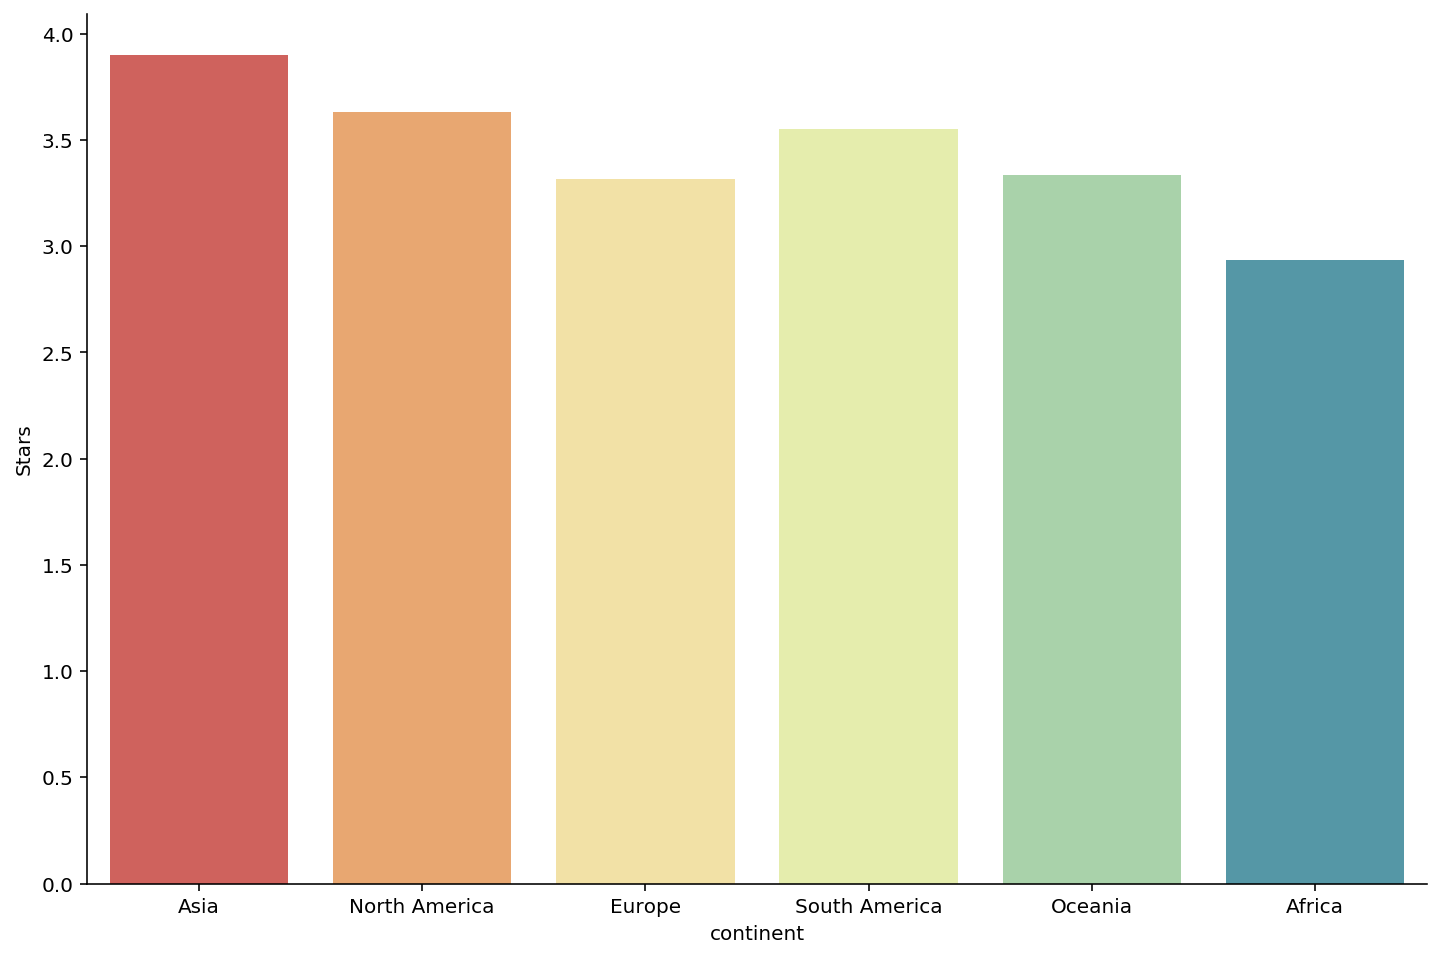

In [13]:
plt.figure(figsize = (12, 8))

barplot_continent_stars = sns.barplot(y = 'Stars', x = 'continent', data = new_df, palette = 'Spectral', ci= None)
#scatterplot.set_xticks(range(17))
#scatterplot.set_xticklabels(values)

# remove the top and right lines
sns.despine()

#labeling the bars
barplot_continent_stars.bar_label(barplot_continent_stars.containers[0])

# add title and axis labels (modify x-axis label)
barplot_continent_stars.set_title('Ratings for each Continent')
barplot_continent_stars.set_ylabel('Stars')
barplot_continent_stars.set_xlabel('Continent');

We can visually see that ramen noodles from the Asian continent tend to have higher `Stars` ratings than that of the other continents. 

We wonder if the spiciness of Asian ramen noodles has to do with this higher rating. Now, we want to see the average star ratings by spiciness.

AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

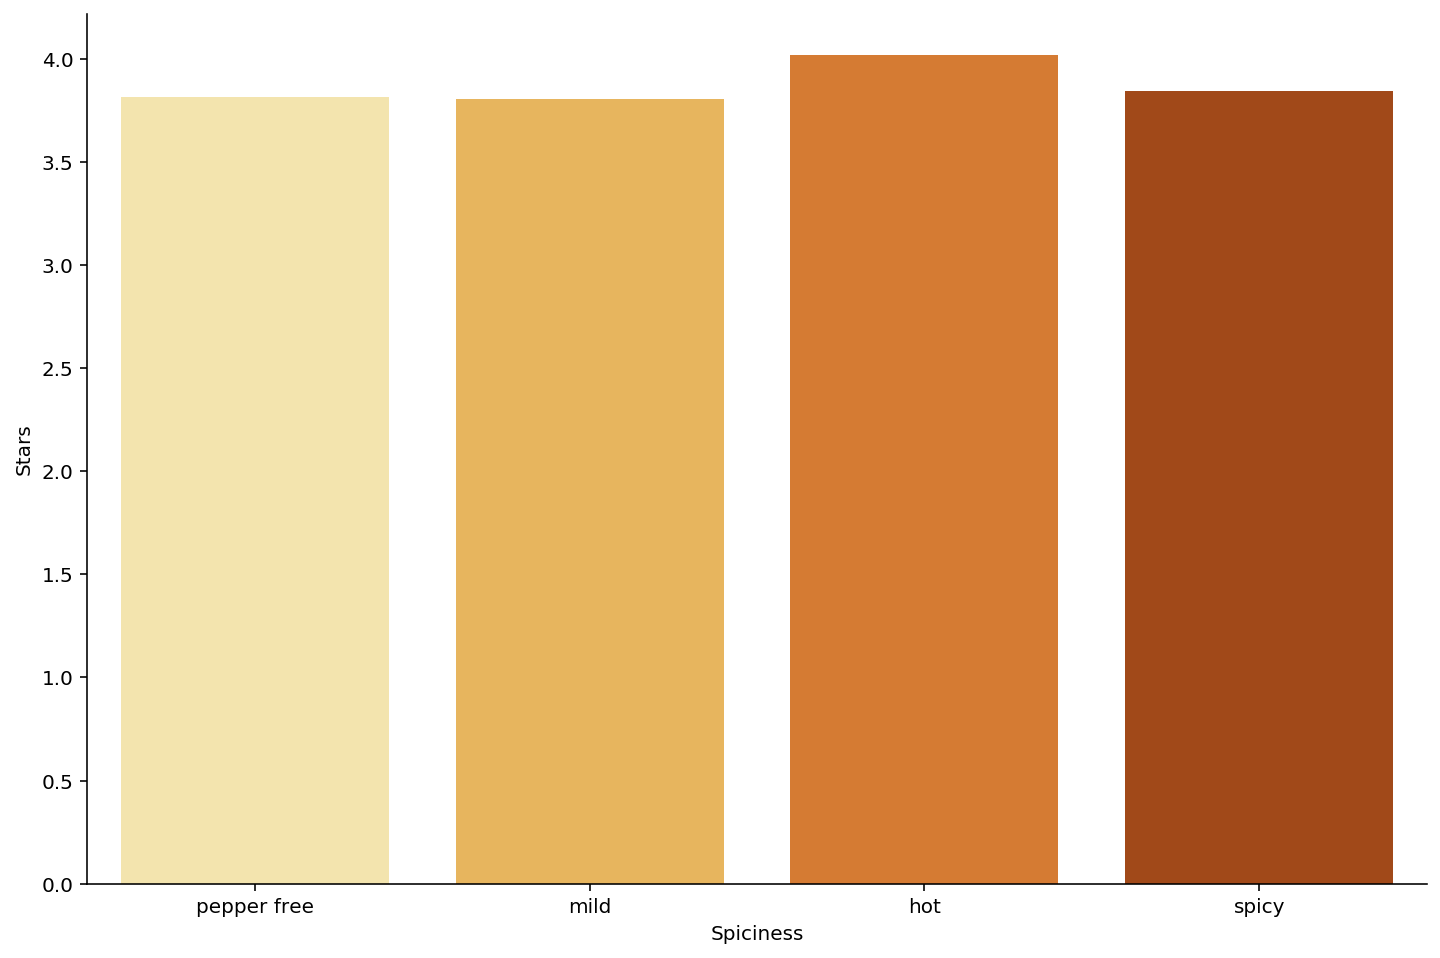

In [14]:
plt.figure(figsize = (12, 8))

barplot_stars_rating = sns.barplot(data = new_df, y = 'Stars', x='Spiciness', palette = 'YlOrBr', ci= None)

# remove the top and right lines
sns.despine()

#labeling the bars
barplot_stars_rating.bar_label(barplot_stars_rating.containers[0])

# add title and axis labels (modify x-axis label)
barplot_stars_rating.set_title('Stars vs Spiciness')
barplot_stars_rating.set_ylabel('Stars')
barplot_stars_rating.set_xlabel('Spiciness');

Based on this barplot, ramen noodles labeled as `hot` tend to have the highest rating compared to other spiciness categories. Now, we want to see if the higher ratings in the Asia noodles have to do with the fact that Asian noodles are more likely to be labeled as `hot`.

AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

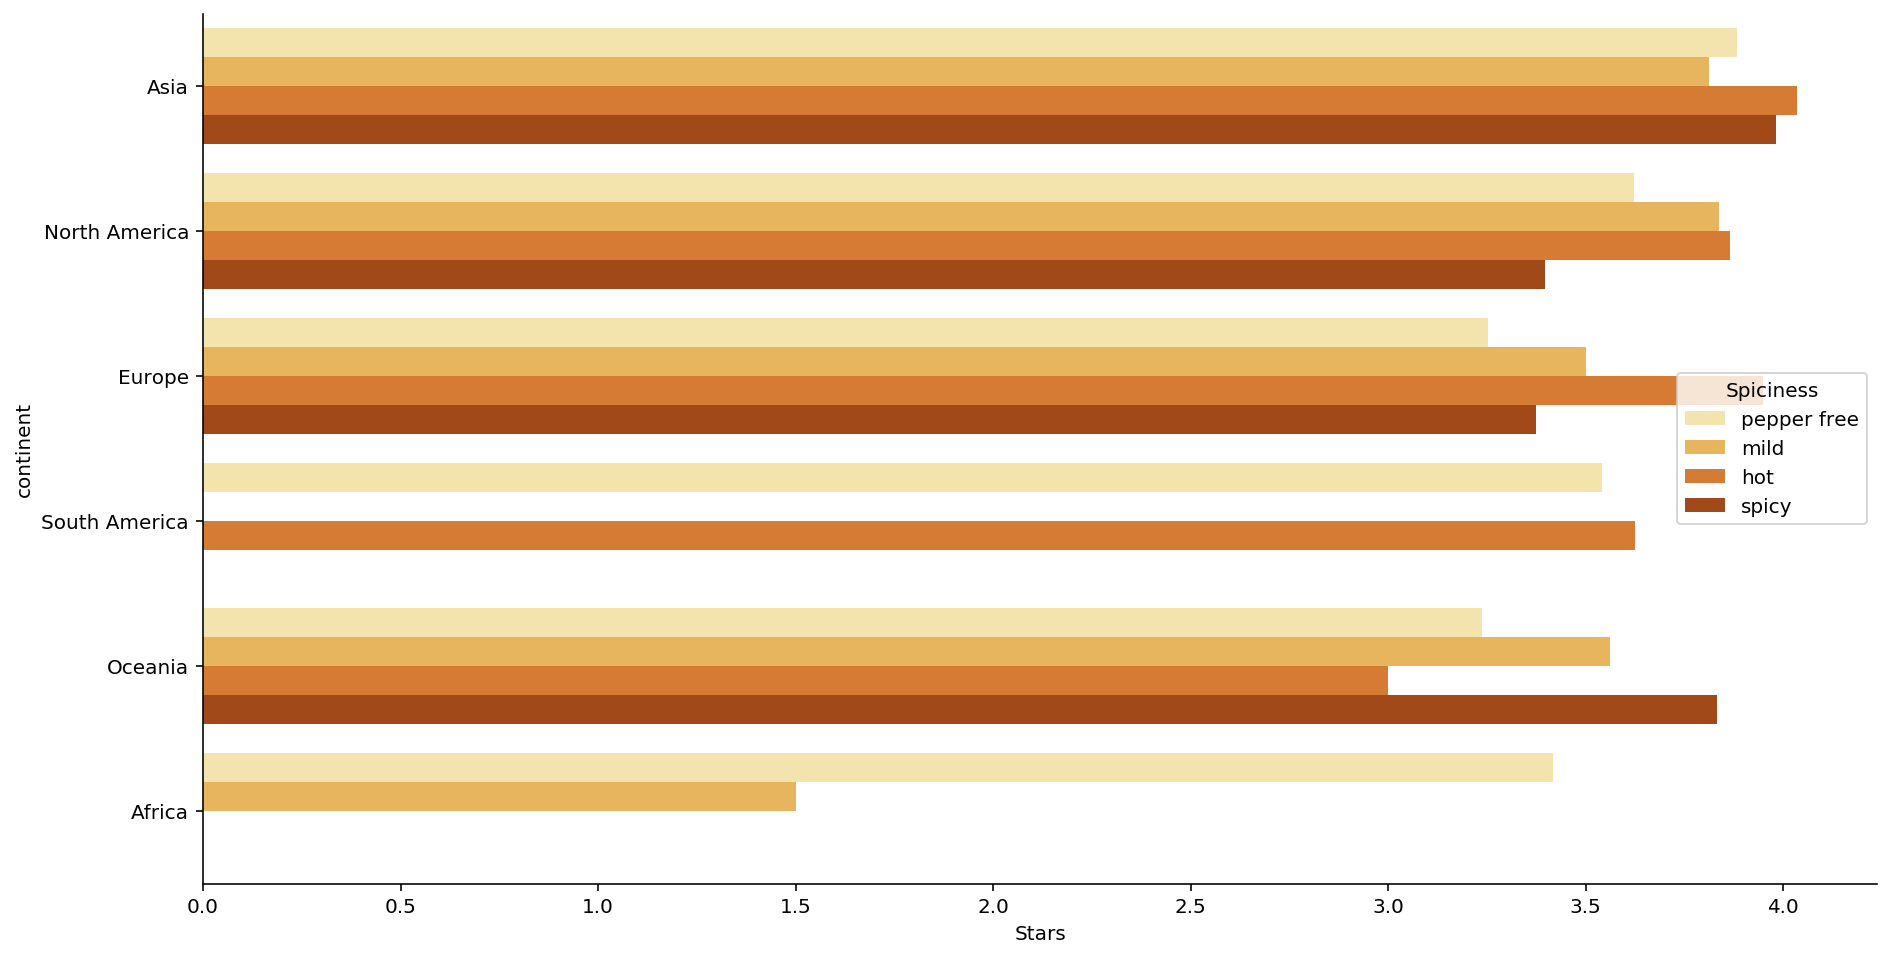

In [15]:
plt.figure(figsize = (15, 8))

barplot_continent_stars_spiciness_2 = sns.barplot(data = new_df, x = 'Stars', y = 'continent', hue = 'Spiciness', palette = 'YlOrBr', ci = None)

# remove the top and right lines
sns.despine()

#labeling bars
for container in barplot_continent_stars_spiciness_2.containers:
    barplot_continent_stars_spiciness_2.bar_label(container)
    
#place legend outside top right corner of plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# add title and axis labels (modify x-axis label)
barplot_continent_stars_spiciness_2.set_title('Spice Level Ratings for every Continent ')
barplot_continent_stars_spiciness_2.set_xlabel('Stars')
barplot_continent_stars_spiciness_2.set_ylabel('Continent');


From the plot above, we can see that `hot` noodles generally have higher star ratings regardless of what continent they are from (with the exclusion of Africa and South America because there is no data). Generally, Asian noodles just have higher ratings relative to other continents. 

We want to take a closer look at the count of noodles in Asia categorized by their spiciness.

In [ ]:
asian_countries = new_df[new_df['continent'] == 'Asia']
asian_countries.sample(5)

plt.figure(figsize = (18, 8))

# asian_countries_count = sns.countplot(y = 'Country', hue='Spiciness', data = asian_countries, palette = 'YlOrBr')
asian_countries_count = sns.countplot(x = 'Country', hue='Spiciness', data = asian_countries, palette = 'YlOrBr')

# remove the top and right lines
sns.despine()

#place legend outside top right corner of plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

#labels for bars
for container in asian_countries_count.containers:
    asian_countries_count.bar_label(container)

# add title and axis labels (modify x-axis label)
asian_countries_count.set_title('Number of Ramen in Asia')
asian_countries_count.set_ylabel('Country')
asian_countries_count.set_xlabel('Ramen');

Based on this count plot, we can see that the majority of ramen noodles are from `Japan`, `South Korea`, and `Taiwan`. Most of those countries either have `pepper free` spiciness. 

Now, we want to see average star ratings for each spiciness level categorized by country.

In [16]:
plt.figure(figsize = (20, 8))

barplot_stars_rating_per_country_na = sns.barplot(data = asian_countries, y = 'Stars', x='Country', hue = 'Spiciness', palette = 'YlOrBr', ci = None)

# remove the top and right lines
sns.despine()

#labels for bars
for container in barplot_stars_rating_per_country_na.containers:
    barplot_stars_rating_per_country_na.bar_label(container)

#place legend outside top right corner of plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# add title and axis labels (modify x-axis label)
barplot_stars_rating_per_country_na.set_title('Ratings for Ramen in Asia')
barplot_stars_rating_per_country_na.set_xlabel('Country')
barplot_stars_rating_per_country_na.set_ylabel('Stars');

NameError: name 'asian_countries' is not defined

<Figure size 1440x576 with 0 Axes>

We observe a general trend of higher star ratings for noodles labeled as `hot` and `spicy` compared to `pepper free` or `mild` in Asian countries.

In [17]:
new_df['continent'].value_counts()

Asia             3107
North America     618
Europe            106
South America      34
Oceania            30
Africa              4
Name: continent, dtype: int64

We want to repeat a similar approach but for North American countries.

AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

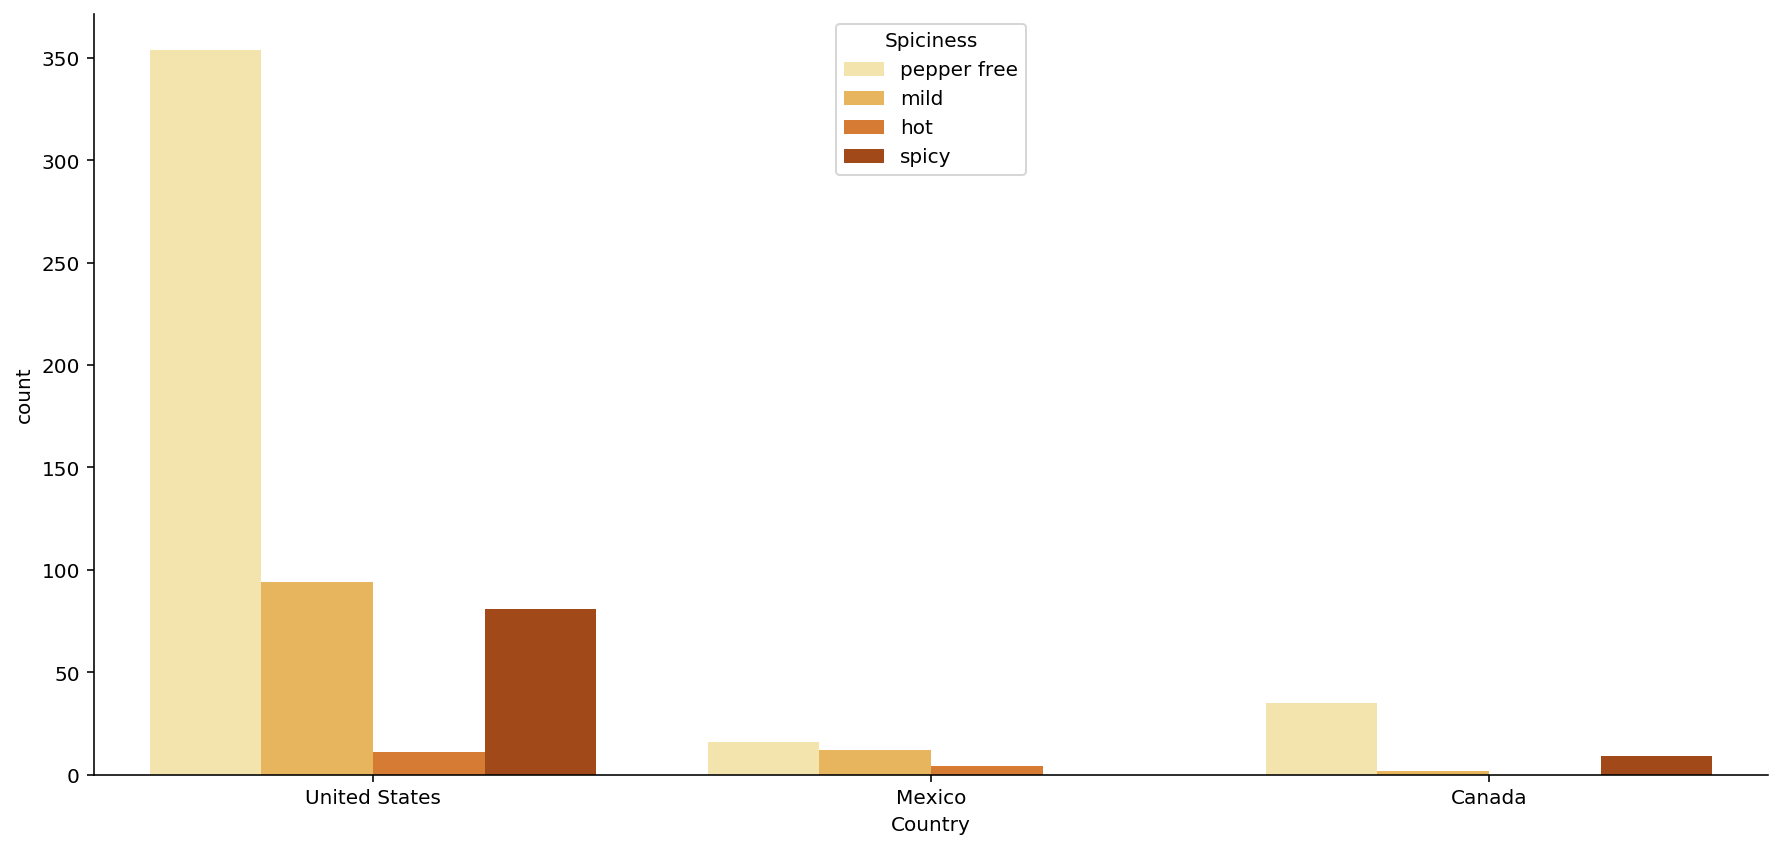

In [18]:
na_countries = new_df[new_df['continent'] == 'North America']
na_countries

plt.figure(figsize = (15, 7))

na_countries_count = sns.countplot(x = 'Country', hue='Spiciness', data = na_countries, palette = 'YlOrBr', 
                                   hue_order = ['pepper free', 'mild', 'hot', 'spicy'])

# remove the top and right lines
sns.despine()

#labels for bars
for container in na_countries_count.containers:
    na_countries_count.bar_label(container)

#place legend outside top right corner of plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# add title and axis labels (modify x-axis label)
na_countries_count.set_title('Number of Ramen from each country in North America')
na_countries_count.set_xlabel('Country')
na_countries_count.set_ylabel('Ramen');

We can see that most of the noodles produced by a North American ramen manufacturers is the `pepper free` ramen. Besides, the U.S. produces a significantly larger amount of ramen noodles compared to Mexico and Canada.

In [ ]:
plt.figure(figsize = (15, 7))

barplot_stars_rating_per_country_na = sns.barplot(data = na_countries, y = 'Stars', x='Country', hue = 'Spiciness', palette = 'YlOrBr', 
                                   hue_order = ['pepper free', 'mild', 'hot', 'spicy'], ci = None)

# remove the top and right lines
sns.despine()

#labels for bars
for container in barplot_stars_rating_per_country_na.containers:
    barplot_stars_rating_per_country_na.bar_label(container)

#place legend outside top right corner of plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# add title and axis labels (modify x-axis label)
barplot_stars_rating_per_country_na.set_title('Ratings for Ramen in North America')
barplot_stars_rating_per_country_na.set_xlabel('Country')
barplot_stars_rating_per_country_na.set_ylabel('Stars');

Unlike the higher star ratings for the spicier ramen in Asia, North American ramen has higher star ratings for more mild ramen (with some missing data in Mexico and Canada).

# Create a map for average star rating
In this part, our group wants to visualize the average star ratings by geographic location to see if there exists any trend between nearby countries.

In [100]:
file = 'ramen.csv'
df = pd.read_csv(file)
# df.astype({'Stars': 'float'})
def star_converted(s):
    rating = s.split('/')[0]
    try:
        return float(rating)
    except ValueError:
        return None
df.Stars= df.Stars.apply(star_converted)

In [101]:
star_df = df.groupby('Country').mean().reset_index()
url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)
country_shapes = f'{url}/world-countries.json'
geoJSON_df = gpd.read_file(country_shapes)
geoJSON_df = geoJSON_df.rename(columns = {"id":"country_code",'name':'Country'})

geoJSON_df['country'] = geoJSON_df['Country'].str.lower().str.replace(' ','')
star_df = star_df.rename(columns = {"Country":"Country_star"})

star_df['country'] =  star_df['Country_star'].str.lower().str.replace(' ','')


final_df = geoJSON_df.merge(star_df, on = "country")

In [102]:
star_df[~star_df['Country_star'].isin(final_df.Country_star.unique())]

,Country_star,Stars,country
13,Hong Kong,3.880488,hongkong
34,Serbia,2.300000,serbia
35,Singapore,4.109375,singapore
43,United States,3.588533,unitedstates


In [103]:
def specific_country(country):
    '''
    convert our df Country columns that have certain countries found differently in folium
    Singapore and Hong Kong do not exist in folium so we will ignore it as they are also small to notice    
    '''
    check_country = country.lower().replace(' ','')
    if 'serbia' in check_country:
        return 'Republic of Serbia'
    elif 'unitedstates' in check_country:
        return 'United States of America'
    return country

In [105]:
star_df = df.groupby('Country').mean().reset_index()
url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)
country_shapes = f'{url}/world-countries.json'
geoJSON_df = gpd.read_file(country_shapes)
geoJSON_df = geoJSON_df.rename(columns = {"id":"country_code",'name':'Country'})
star_df['Country'] = star_df['Country'].apply(specific_country)

geoJSON_df['country'] = geoJSON_df['Country'].str.lower().str.replace(' ','')
star_df = star_df.rename(columns = {"Country":"Country_star"})

star_df['country'] =  star_df['Country_star'].str.lower().str.replace(' ','')


final_df = geoJSON_df.merge(star_df, on = "country")
# final_df = final_df.drop(columns=['country'])
def get_lat_long(pt):
    '''
    Get centroid point of a state
    '''
    return (pt.y, pt.x)
final_df['coor'] = final_df['geometry'].centroid.apply(get_lat_long)
m = folium.Map(location=[48, -102], zoom_start=3)
folium.Choropleth(
    #The GeoJSON data to represent the world country
    geo_data=country_shapes,
    name='Ramen World',
    data=final_df,
    #The column aceppting list with 2 value; The country name and  the numerical value
    columns=['Country', 'Stars'],
    key_on='feature.properties.name',
    fill_color='PuRd',
    # nan_fill_color='white'
).add_to(m)

# nans = df[df["Stars"].isnull()]['POSTAL.CODE'].values
# gdf_nans = df[df['POSTAL.CODE'].isin(nans)]
sp = StripePattern(angle=45, color='grey', space_color='white')

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}

# # Add hover functionality.
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    data = final_df,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['Country','Stars',],
        aliases=['Country','Star rating',],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
m.add_child(NIL)
m.keep_in_front(NIL)
folium.TileLayer('Stamen Toner').add_to(m)
folium.TileLayer('Stamen Water Color').add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)
folium.TileLayer('cartodbdark_matter').add_to(m)
folium.LayerControl(collapsed=True).add_to(m)
m

D:\Huy\python\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Based on our encoding, the darker color signifies a higher average star rating. Lighter shade of pink shows a lower average star rating.

According to our choropleth, most of the countries closer to the equator have higher average star ratings than the countries closer to the poles. Moreover, nearby countries tend to have similar average star ratings.

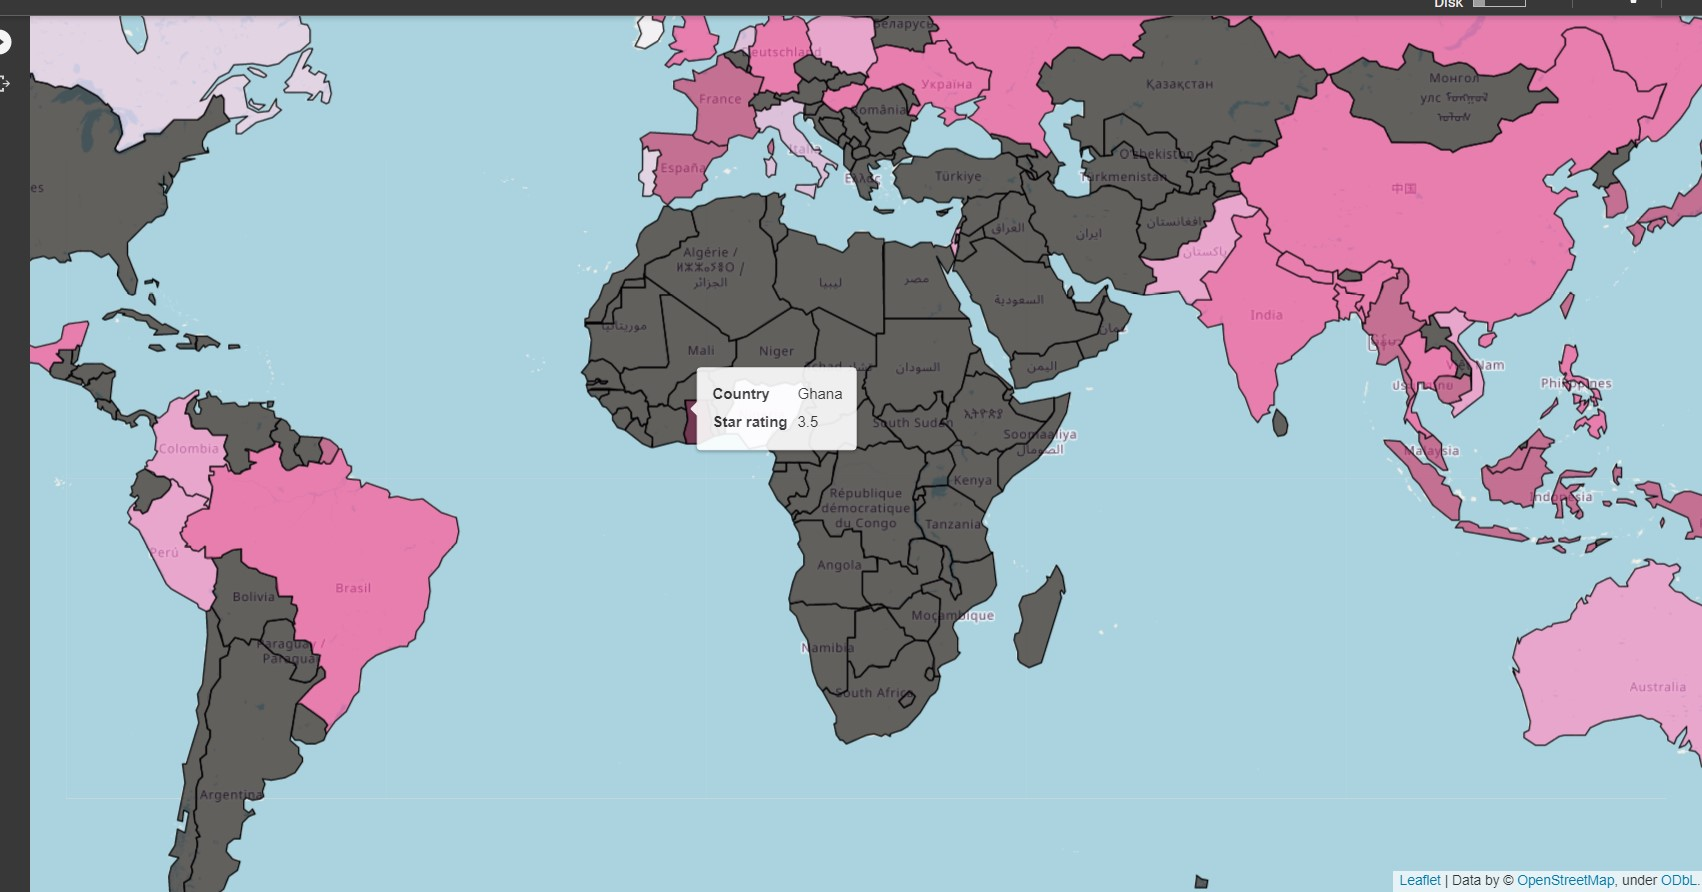

In [21]:
from IPython.display import Image
Image(filename='pictures/ghana.jpg') 

We can also change the layer of the map to be aesthetic

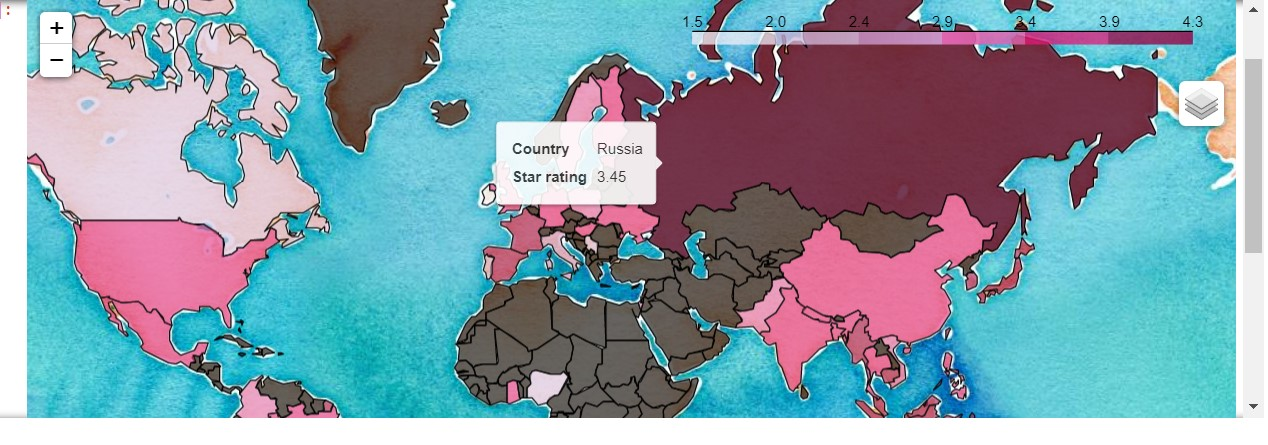

In [106]:
Image(filename='pictures/russia.jpg') 

# Other Considerations
This analysis is confined by our dataset. Not all of the ramen noodles are available for analysis, and the feature engineering implementation is not flawless.

There is no hard metric for the star ratings. The star ratings is from the one reviewer on the blog. The higher star ratings might reflect his preference for spicy food.